# Credits
> This code is a slight modification to a translation (TensorFlow --> PyTorch) of a previous version of the [02456](http://kurser.dtu.dk/course/02456) course material. 
> [Original repo link (TensorFlow)](https://github.com/DeepLearningDTU/02456-deep-learning).
> [Translated repo link (PyTorch)](https://github.com/munkai/pytorch-tutorial/tree/master/2_intermediate).

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

![MNIST.Exampel](../static_files/mnist.png)


## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [2]:
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

In [3]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 784).float().cuda()
targets_train = mnist_trainset.targets[:1000].cuda()

x_valid = mnist_trainset.data[1000:1500].view(-1, 784).float().cuda()
targets_valid = mnist_trainset.targets[1000:1500].cuda()

x_test = mnist_testset.data[:500].view(-1, 784).float().cuda()
targets_test = mnist_testset.targets[:500].cuda()

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([1000, 784])
targets_train torch.Size([1000])
x_valid torch.Size([500, 784])
targets_valid torch.Size([500])
x_test torch.Size([500, 784])
targets_test torch.Size([500])


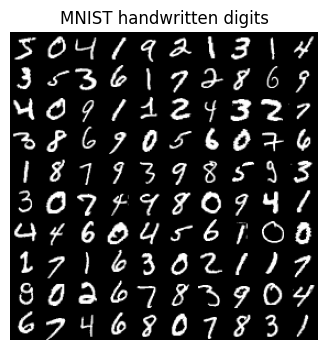

In [4]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim)).cpu()
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Model

One of the large challenges in deep learning is the amount of hyperparameters that needs to be selected, and the lack of a good principled way of selecting them.
Hyperparameters can be found by experience (guessing) or some search procedure (often quite slow).
Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [Spearmint](https://github.com/JasperSnoek/spearmint) and many others.

**In practice a lot of trial and error is almost always involved.** This can be frustrating and time consuming, but the best thing to do is to think as a scientist, and go about it in a ordered manner --> monitor as much as you can, take notes, and be deliberate!

Below are some guidelines that you can use as a starting point to some of the most important hyperparameters. 
(*regularization* is also very important, but will be covered later.)


### Ballpark estimates of hyperparameters
__Number of hidden units and network structure:__
You'll have to experiment. One rarely goes below 512 units for feedforward networks (unless your are training on CPU...).
There's some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Parameter initialization:__
Parameter initialization is extremely important.
PyTorch has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaiming He
2. kaiming Glorot
3. Uniform or Normal with small scale (0.1 - 0.01)
4. Orthogonal (this usually works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Mini-batch size:__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory, which means you can train a model with more parameters.

__Nonlinearity:__ [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
1. ReLU
2. Leaky ReLU
3. ELU
3. Sigmoid (rarely, if ever, used in hidden layers anymore, squashes the output to the interval [0, 1] - appropriate if the targets are binary.
4. Tanh is similar to the sigmoid, but squashes to [-1, 1]. Rarely used any more.
4. Softmax normalizes the output to 1, usrful if you have a multi-class classification problem.

See the plot below.

__Optimizer and learning rate:__
1. SGD + Momentum: learning rate 0.01 - 0.1 
2. ADAM: learning rate 3e-4 - 1e-5
3. RMSPROP: somewhere between SGD and ADAM


softmax should sum to one (approxiamtely): 1.0


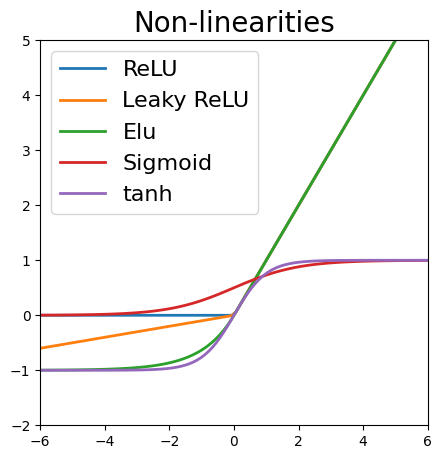

In [5]:
# Illustrate different output units
x = np.linspace(-6, 6, 100)
units = {
    "ReLU": lambda x: np.maximum(0, x),
    "Leaky ReLU": lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x),
    "Elu": lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1),
    "Sigmoid": lambda x: (1 + np.exp(-x))**(-1),
    "tanh": lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# assert that all class probablities sum to one
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))
print("softmax should sum to one (approxiamtely):", np.sum(softmax(x)))

In [6]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, layers, dropout = 0.0):
        super(Net, self).__init__()  
        self.weights = nn.ParameterList()
        self.biases = nn.ParameterList()
        self.batchnorms = []
        self.no_of_layers = len(layers)
        # input layer
        for layer in layers:
            self.weights.append(Parameter(init.kaiming_normal_(torch.Tensor(layer[1], layer[0]))).cuda())
            self.biases.append(Parameter(init.constant_(torch.Tensor(layer[1]), 0).cuda()))
            self.batchnorms.append(torch.nn.BatchNorm1d(layer[1]).cuda())
        # define activation function in constructor
        self.activation = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout2d(dropout)

    def forward(self, x):
        for i in range(self.no_of_layers-1):
            x = F.linear(x, self.weights[i], self.biases[i])
            x = self.batchnorms[i](x)
            x = self.dropout(x)
            x = self.activation(x)
        x = F.linear(x, self.weights[self.no_of_layers-1], self.biases[self.no_of_layers-1])
        return x
    def set_dropout(self, dropout):
        self.dropout = torch.nn.Dropout(dropout)

layers =[[x_train.shape[1], 512],
        [512, 256],
        [256, 32],
        [32, num_classes]]


net = Net(layers).cuda()

In [7]:
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [8]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(torch.from_numpy(x).cuda()).size())

torch.Size([45, 10])


/home/topnotches/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

Epoch  1 : Train Loss 0.285315 , Train acc 0.211000, Valid acc 0.148000
Epoch 11 : Train Loss 0.172308 , Train acc 0.715000, Valid acc 0.628000
Epoch 21 : Train Loss 0.138828 , Train acc 0.814000, Valid acc 0.724000
Epoch 31 : Train Loss 0.117007 , Train acc 0.874000, Valid acc 0.780000
Epoch 41 : Train Loss 0.104528 , Train acc 0.895000, Valid acc 0.802000
Epoch 51 : Train Loss 0.091890 , Train acc 0.913000, Valid acc 0.812000
Epoch 61 : Train Loss 0.086441 , Train acc 0.923000, Valid acc 0.824000
Epoch 71 : Train Loss 0.081766 , Train acc 0.941000, Valid acc 0.842000
Epoch 81 : Train Loss 0.074767 , Train acc 0.948000, Valid acc 0.850000
Epoch 91 : Train Loss 0.070407 , Train acc 0.959000, Valid acc 0.860000


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

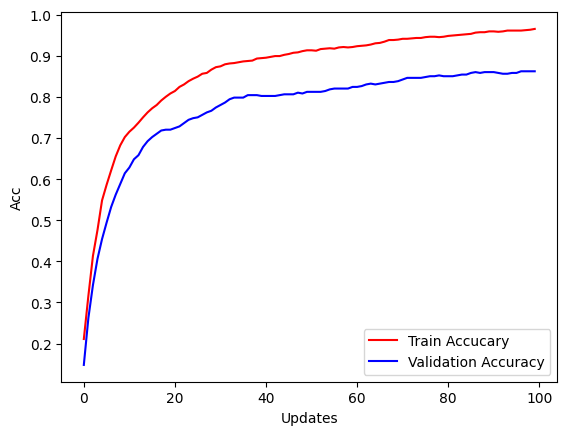

In [9]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 100
dropout = 0.4
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    net.set_dropout(dropout)
    targets_train = targets_train.cuda()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1].cpu()
        train_targs += list(targets_train[slce].cpu().numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1].cpu()
        val_targs += list(targets_valid[slce].cpu().numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of kaiming Glorot (DONE)
- add an extra layer (DONE, added multiple layers)
- use the relu activation function (DONE, I also added LeakyReLU to avoid dead neurons)
- add momentum to the optimizer (DONE)
- use the ADAM optimizer instead of stochastic gradient descent (DONE)

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on clever use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay)  (DONE, I added weight decay (l2) to the Adam Optimizer)
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code) (DONE, see net class)
- add batchnorm (DONE)

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    

You are done for now. [Good job.](https://media1.tenor.com/images/0fd559b07f2174f9b8b7dbde7c5a67ca/tenor.gif)

EXERCISE FROM CHAPTER 3 OF BOOK "ROTATION OF MNIST"

EXERCISE DESCRIPTION FROM THE BOOK:
As discussed above, one way of expanding the MNIST training data is to use small rotations of training images. What's a problem that might occur if we allow arbitrarily large rotations of training images? 

ANSWER:
Let's start by loading the dataset and performing some random rotations on the loaded data 

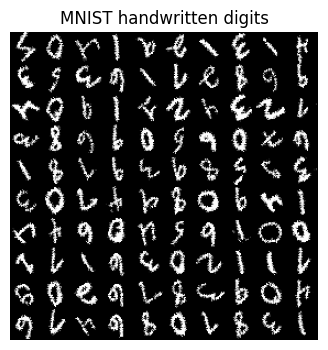

In [10]:
# We reload mnist data
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

import torchvision.transforms as T
torch.manual_seed(17)

# We define a sequential image augmentation network
augmentation = torch.nn.Sequential(
    T.RandomRotation((-360,360)),
    T.RandomRotation((-360,360)),
    T.RandomRotation((-360,360))
    )

x_train = augmentation(mnist_trainset.data[:1000]).view(-1, 784).float().cuda()
targets_train = mnist_trainset.targets[:1000].cuda()

x_valid = augmentation(mnist_trainset.data[1000:1500]).view(-1, 784).float().cuda()
targets_valid = mnist_trainset.targets[1000:1500].cuda()

x_test = augmentation(mnist_testset.data[:500]).view(-1, 784).float().cuda()
targets_test = mnist_testset.targets[:500].cuda()


# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim)).cpu()
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

We can see that the images are rotated with some noise added, let's see how the network fairs at training on the dataset:

Epoch  1 : Train Loss 0.269118 , Train acc 0.275000, Valid acc 0.074000
Epoch  2 : Train Loss 0.254702 , Train acc 0.387000, Valid acc 0.080000
Epoch  3 : Train Loss 0.240530 , Train acc 0.494000, Valid acc 0.078000
Epoch  4 : Train Loss 0.227989 , Train acc 0.560000, Valid acc 0.070000
Epoch  5 : Train Loss 0.216080 , Train acc 0.618000, Valid acc 0.068000
Epoch  6 : Train Loss 0.209691 , Train acc 0.661000, Valid acc 0.068000
Epoch  7 : Train Loss 0.196008 , Train acc 0.692000, Valid acc 0.076000
Epoch  8 : Train Loss 0.188811 , Train acc 0.716000, Valid acc 0.078000
Epoch  9 : Train Loss 0.184779 , Train acc 0.736000, Valid acc 0.076000
Epoch 10 : Train Loss 0.178561 , Train acc 0.754000, Valid acc 0.078000
Epoch 11 : Train Loss 0.174827 , Train acc 0.767000, Valid acc 0.080000
Epoch 12 : Train Loss 0.169230 , Train acc 0.777000, Valid acc 0.082000
Epoch 13 : Train Loss 0.165548 , Train acc 0.786000, Valid acc 0.088000
Epoch 14 : Train Loss 0.159370 , Train acc 0.806000, Valid acc 0

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

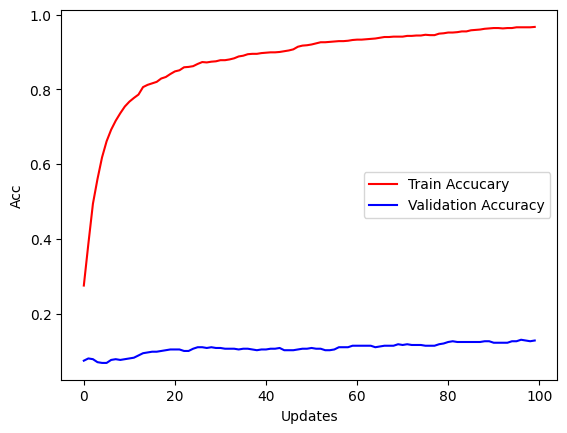

In [11]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 100
dropout = 0.4
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size


layers =[[x_train.shape[1], 512],
        [512, 256],
        [256, 32],
        [32, num_classes]]

note = Net(layers).cuda()
note.set_dropout(.5)
optimizer = optim.Adam(note.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []
get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    note.train()
    note.set_dropout(dropout)
    targets_train = targets_train.cuda()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = note(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    note.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = note(x_train[slce])
        
        preds = torch.max(output, 1)[1].cpu()
        train_targs += list(targets_train[slce].cpu().numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = note(x_valid[slce])
        preds = torch.max(output, 1)[1].cpu()
        val_targs += list(targets_valid[slce].cpu().numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
            epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')


We can see by the random rotation transform that the network only learns the training data, ie. overfitting is occuring. Arbitrarily large rotations, creates a great variation in data with seamingly no significant set of features for a given class, or rather, the net is not learning how to detect the features that are shared for a given class. This is especially the case when using Neural Nets based on fully-connected layers, dense layers, where each trained weight is connected to a specific input, eg. a weight and a pixel. These hard-connections make FC-layers highly sensitive to spatial transforms in images.

As an example the digit '7' has certain local features that makes us able to recognize it. This could be the two lines coming together and forming a sharp corner. If we were to move this digit by a couple of pixels we would still recognize it as the digit '7'. However even small spatial transform such as moving the digit w.r.t. the image center can have a big effect on nets based on FC-layers

Let's take another example of the FC-layer based network where we instead offset the images by some pixels, eg. move the digit in w.r.t. the image center:

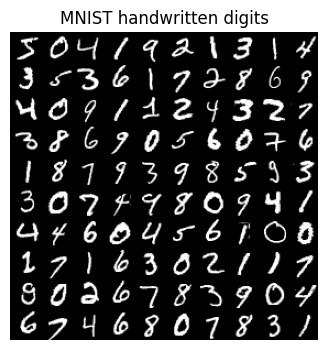

In [12]:
# We reload mnist data
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

import torchvision.transforms as T
torch.manual_seed(17)

# We define a sequential image augmentation network
augmentation_translate = torch.nn.Sequential(
    T.RandomRotation((90,90)),
    T.RandomAffine(degrees = 0, translate = (0.0,0.1)),
    T.RandomRotation((-90,-90)),
    )

x_train = augmentation_translate(mnist_trainset.data[:1000]).view(-1, 28*28).float().cuda()
targets_train = mnist_trainset.targets[:1000].cuda()

x_valid = augmentation_translate(mnist_trainset.data[1000:1500]).view(-1, 28*28).float().cuda()
targets_valid = mnist_trainset.targets[1000:1500].cuda()

x_test = augmentation_translate(mnist_testset.data[:500]).view(-1, 28*28).float().cuda()
targets_test = mnist_testset.targets[:500].cuda()


# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim)).cpu()
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

For the image transform we use random affine with a maximum translation of up to 10% of the images width. We will now see the training result with an identical network as shown through this entire document.

Epoch  1 : Train Loss 0.284709 , Train acc 0.215000, Valid acc 0.126000
Epoch  2 : Train Loss 0.268848 , Train acc 0.319000, Valid acc 0.160000
Epoch  3 : Train Loss 0.246798 , Train acc 0.417000, Valid acc 0.202000
Epoch  4 : Train Loss 0.238512 , Train acc 0.484000, Valid acc 0.248000
Epoch  5 : Train Loss 0.223450 , Train acc 0.551000, Valid acc 0.288000
Epoch  6 : Train Loss 0.213289 , Train acc 0.607000, Valid acc 0.318000
Epoch  7 : Train Loss 0.204411 , Train acc 0.643000, Valid acc 0.344000
Epoch  8 : Train Loss 0.196344 , Train acc 0.689000, Valid acc 0.368000
Epoch  9 : Train Loss 0.189119 , Train acc 0.719000, Valid acc 0.390000
Epoch 10 : Train Loss 0.179133 , Train acc 0.749000, Valid acc 0.416000
Epoch 11 : Train Loss 0.172906 , Train acc 0.780000, Valid acc 0.428000
Epoch 12 : Train Loss 0.176020 , Train acc 0.794000, Valid acc 0.450000
Epoch 13 : Train Loss 0.161425 , Train acc 0.804000, Valid acc 0.456000
Epoch 14 : Train Loss 0.161463 , Train acc 0.811000, Valid acc 0

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

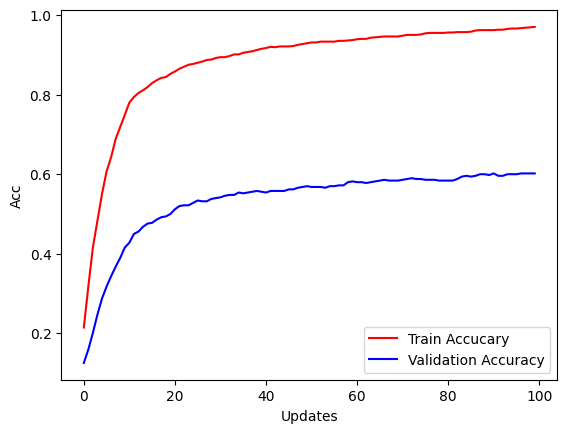

In [13]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 100
dropout = 0.4
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size


layers =[[x_train.shape[1], 512],
        [512, 256],
        [256, 32],
        [32, num_classes]]

scote = Net(layers).cuda()
scote.set_dropout(.5)
optimizer = optim.Adam(scote.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []
get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    scote.train()
    scote.set_dropout(dropout)
    targets_train = targets_train.cuda()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = scote(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    scote.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = scote(x_train[slce])
        
        preds = torch.max(output, 1)[1].cpu()
        train_targs += list(targets_train[slce].cpu().numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = scote(x_valid[slce])
        preds = torch.max(output, 1)[1].cpu()
        val_targs += list(targets_valid[slce].cpu().numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
            epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')


Using the same hyper-parameters as previously, we see that using a small offset in position of only up to 10% of the width of each image, the FC-layer has a hard time learning the general features of the handwritten digits. Ie. it has a lower validation accuracy. A higher offset should even have a significantly more adverse effect on the validation/test accuracy. Luckily we can make use of CNN's instead of FNN's as they should provide much better result due to their ability to extract local features of the data.